In [1]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from ddm.run_split import SplitMnistGenerator
from ddm.alg.cla_models_multihead import MFVI_IBP_NN, MFVI_NN, Vanilla_NN
from ddm.alg.utils import get_scores, concatenate_results
from ddm.alg.vcl import run_vcl
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

W0821 19:42:21.077231 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0821 19:42:21.078042 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:13: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



# Weight pruning

In [2]:
class MFVI_IBP_NN_prune(MFVI_IBP_NN):
    def __init__(self, input_size, hidden_size, output_size, training_size, num_ibp_samples=10,
                 no_train_samples=10, no_pred_samples=100, prev_means=None, prev_log_variances=None,
                 prev_betas=None, learning_rate=0.001,
                 prior_mean=0, prior_var=1, alpha0=5., beta0=1., lambda_1=1., lambda_2=1.,
                 tensorboard_dir='logs', name='ibp_wp', min_temp=0.5, tb_logging=True,
                output_tb_gradients=True):

        super(MFVI_IBP_NN_prune, self).__init__(input_size, hidden_size, output_size, training_size,
                 no_train_samples, no_pred_samples, num_ibp_samples, prev_means, prev_log_variances,
                 prev_betas, learning_rate,
                 prior_mean, prior_var, alpha0, beta0, lambda_1, lambda_2,
                 tensorboard_dir, name, min_temp, tb_logging, output_tb_gradients=True)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning.
        
        Z is at a data level doesn't make sense to introduce this intot he mask over weights which get zeroed 
        out. Simlpy running the accuracy over the graph will entail that Z is incorporated into the 
        matrix math for the prediction calculations.
        
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                new_weights: list of new tf weight variables which wil
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues) / sigmavalues)
                
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                #self.sess.run(tf.assign(s, np.multiply(self.sess.run(s), mask)))  # also apply zero std to weight!!!
                
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id,
                                                     self.temp: self.lambda_1,
                                                     self.training: False}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        # TODO get head weights and biases
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        acc = self.sess.run(self.acc, {self.x: X_test,
                                    self.y: Y_test,
                                    self.task_idx: task_id,
                                    self.temp: self.lambda_1,
                                    self.training: False}) # z mask for each layer in a list, each Z \in dout
        print("test acc: {}".format(acc))
        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]
        
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + mus_h]))
        sigmavalues = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        ya_ibp = []
        for pct in xs:
            ya_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                              sigmas_w + sigmas_b + sigmas_h, uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        yb_ibp = []
        for pct in xs:
            yb_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                                  sigmas_w + sigmas_b + sigmas_h, uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        
        #return xs, ya, yb, ya_ibp, yb_ibp
        return xs, ya_ibp, yb_ibp

# Multiclass CLF Weight Pruning

In [3]:
class MnistGenerator():
    def __init__(self, max_iter=10):
        with gzip.open('ddm/data/mnist.pkl.gz', 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

        self.X_train = np.vstack((train_set[0], valid_set[0]))
        self.Y_train = np.hstack((train_set[1], valid_set[1]))
        self.X_test = test_set[0]
        self.Y_test = test_set[1]
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return self.X_train.shape[1], 10

    def task(self):
        # Retrieve train data
        x_train = deepcopy(self.X_train)
        y_train = np.eye(10)[self.Y_train]

        # Retrieve test data
        x_test = deepcopy(self.X_test)
        y_test = np.eye(10)[self.Y_test]
        
        return x_train, y_train, x_test, y_test

In [4]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    mf_betas = None
    ml_model.close_session()

# Train on non-coreset data
mf_model = MFVI_IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], 
                             num_ibp_samples=10, prev_means=mf_weights, 
                       prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=5.0, beta0=1.0,
                       learning_rate=0.0001, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                       name='ibp_wp_mnist')

mf_model.restore(os.path.join("logs", "graph_{}_task{}".format('ibp_wp_mnist', 0)))
# mf_model.train(x_train, y_train, head, no_epochs, bsize,
#               anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)

xs, ya_ibp, yb_ibp  = mf_model.prune_weights(x_test, y_test, head)

mf_model.close_session()

W0821 19:42:22.788784 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:56: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 19:42:22.792086 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:177: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0821 19:42:22.862715 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:61: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0821 19:42:22.997229 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:65: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



Epoch: 0001 cost= 0.417946803
Epoch: 0006 cost= 0.075792010
Epoch: 0011 cost= 0.037298302
Epoch: 0016 cost= 0.019005517
Epoch: 0021 cost= 0.009970345
Epoch: 0026 cost= 0.005601576
Epoch: 0031 cost= 0.001965217
Epoch: 0036 cost= 0.000851523
Epoch: 0041 cost= 0.000607356
Epoch: 0046 cost= 0.004467624
Epoch: 0051 cost= 0.000259006
Epoch: 0056 cost= 0.004487546
Epoch: 0061 cost= 0.000172686
Epoch: 0066 cost= 0.000112348
Epoch: 0071 cost= 0.000389601
Epoch: 0076 cost= 0.000091579
Epoch: 0081 cost= 0.000058314
Epoch: 0086 cost= 0.001865642
Epoch: 0091 cost= 0.000073635
Epoch: 0096 cost= 0.000040658


W0821 19:43:13.055495 140264918792000 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:575: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Optimization Finished!
(1, ?, 100)
<unknown>


W0821 19:43:13.313542 140264918792000 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:528: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>


W0821 19:43:13.779579 140264918792000 deprecation.py:323] From /home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0821 19:43:14.644345 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:555: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W0821 19:43:14.731306 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:535: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0821 19:43:14.762229 140264918792000 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:670: The n

_Z: (1, ?, 100)
Un-matched: w_0:0
Un-matched: b_0:0
Un-matched: w_h_0:0
Un-matched: b_h_0:0
Un-matched: beta_a_0:0
Un-matched: beta_b_0:0
test acc: 0.9486740231513977
0.00, 0.9483735
0.05, 0.9485658
0.10, 0.94854087
0.15, 0.9485385
0.20, 0.94814193
0.25, 0.94832736
0.30, 0.948668
0.35, 0.9484043
0.40, 0.9482589
0.45, 0.9484416
0.50, 0.94873846
0.55, 0.948386
0.60, 0.948174
0.65, 0.9484037
0.70, 0.9488484
0.75, 0.9484024
0.80, 0.9483946
0.85, 0.947657
0.90, 0.93643504
0.95, 0.8419142
0.98, 0.47161478
0.99, 0.2572486
1.00, 0.1097814
0.00, 0.9486372
0.05, 0.9484426
0.10, 0.94795275
0.15, 0.94825983
0.20, 0.9483253
0.25, 0.9483965
0.30, 0.94781655
0.35, 0.94860137
0.40, 0.94833195
0.45, 0.94822294
0.50, 0.9480139
0.55, 0.9486286
0.60, 0.94865406
0.65, 0.9486963
0.70, 0.94841385
0.75, 0.94820136
0.80, 0.9483887
0.85, 0.9480044
0.90, 0.9463827
0.95, 0.928347
0.98, 0.75886744
0.99, 0.4000272
1.00, 0.0882204


/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/ma

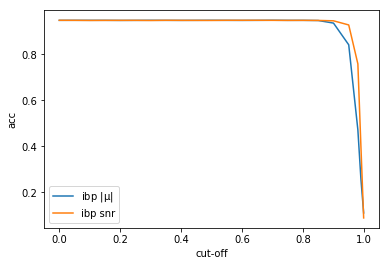

In [5]:
#plt.plot(xs, ya, label='$|\mu|$')
#plt.plot(xs, yb, label='snr')
plt.plot(xs, ya_ibp, label='ibp $|\mu|$')
plt.plot(xs, yb_ibp, label='ibp snr')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()

# No IBP

In [6]:
class MFVI_NN_prune(MFVI_NN):
    def __init__(self, input_size, hidden_size, output_size, training_size, 
        no_train_samples=10, no_pred_samples=100, prev_means=None, prev_log_variances=None, learning_rate=0.001, 
        prior_mean=0, prior_var=1):

        super(MFVI_NN_prune, self).__init__(input_size, hidden_size, output_size, training_size, 
        no_train_samples, no_pred_samples, prev_means, prev_log_variances, learning_rate, 
        prior_mean, prior_var)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning.
        
        Z is at a data level doesn't make sense to introduce this intot he mask over weights which get zeroed 
        out. Simlpy running the accuracy over the graph will entail that Z is incorporated into the 
        matrix math for the prediction calculations.
        
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues) / sigmavalues)
                
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]
        
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + mus_h]))
        sigmavalues = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        # pruning
        ya = []
        for pct in xs:
            ya_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                              sigmas_w + sigmas_b + sigmas_h, uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        yb = []
        for pct in xs:
            yb_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                                  sigmas_w + sigmas_b + sigmas_h, uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        
        return xs, ya, yb

In [ ]:
hidden_size = [100]
batch_size = 128
no_epochs = 500

tf.set_random_seed(12)
np.random.seed(1)

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    ml_model.close_session()

# Train on non-coreset data
mf_model = MFVI_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                         prev_log_variances=mf_variances)

mf_model.train(x_train, y_train, head, no_epochs, bsize)

xs, ya, yb  = mf_model.prune_weights(x_test, y_test, head)

mf_model.close_session()

Epoch: 0001 cost= 0.423908216
Epoch: 0006 cost= 0.074809015
Epoch: 0011 cost= 0.034873054
Epoch: 0016 cost= 0.017029525
Epoch: 0021 cost= 0.008828043
Epoch: 0026 cost= 0.005183751
Epoch: 0031 cost= 0.004760422
Epoch: 0036 cost= 0.000991851
Epoch: 0041 cost= 0.000453620
Epoch: 0046 cost= 0.001089015
Epoch: 0051 cost= 0.000240368
Epoch: 0056 cost= 0.000249355
Epoch: 0061 cost= 0.000135572
Epoch: 0066 cost= 0.011170367
Epoch: 0071 cost= 0.000105972
Epoch: 0076 cost= 0.000064127
Epoch: 0081 cost= 0.000742145
Epoch: 0086 cost= 0.000067122
Epoch: 0091 cost= 0.000039976
Epoch: 0096 cost= 0.003797296
Optimization Finished!
Epoch: 0001 cost= 3.228416839
Epoch: 0006 cost= 2.006878323
Epoch: 0011 cost= 1.208152405
Epoch: 0016 cost= 0.899522673
Epoch: 0021 cost= 0.783278817
Epoch: 0026 cost= 0.700111097
Epoch: 0031 cost= 0.634223401
Epoch: 0036 cost= 0.581039405
Epoch: 0041 cost= 0.532690271
Epoch: 0046 cost= 0.493331300
Epoch: 0051 cost= 0.460849917
Epoch: 0056 cost= 0.432339303
Epoch: 0061 cost=

In [ ]:
plt.plot(xs, ya, label='$|\mu|$')
plt.plot(xs, yb, label='snr')
plt.plot(xs, ya_ibp, label='ibp $|\mu|$')
plt.plot(xs, yb_ibp, label='ibp snr')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()

# Split

In [ ]:
hidden_size = [100]
batch_size = 128
no_epochs = 200
alpha0 = 1.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = False
data_gen = SplitMnistGenerator(val, num_tasks=1)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=0.01, lambda_1=tau0, lambda_2=1.0, no_pred_samples=100)
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    
    xs, ya, yb, ya_ibp, yb_ibp  = mf_model.prune_weights(x_test, y_test, head)
    
    mf_model.close_session()